In [1]:
from pathlib import Path

import pandas as pd
import networkx as nx

from src import preprocess, plotutils

In [2]:
import spacy

spacy_pipeline = spacy.load("en_core_web_sm")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
DATA_DIR = "./data/"
CLINICAL_NOTES_FILE = DATA_DIR + "ClinNotes.csv"
MEDICAL_CONCEPTS_FILE = DATA_DIR + "MedicalConcepts.csv"

PROCESSDED_DATA_DIR = './processed_data/'
PROCESSED_CLINICAL_NOTES_FILE = PROCESSDED_DATA_DIR + "ClinNotes.csv"
NORMALIZED_CLINICAL_NOTES_FILE = PROCESSDED_DATA_DIR + "ClinNotes_normalized.csv"
EXTENDED_CLINICAL_NOTES_FILE = PROCESSDED_DATA_DIR + "ClinNotes_normalized_extended.csv"

# Clinical Notes

In this notebook, we will conduct some exploratory data analysis to understand the pattern of our clinical note data. As it is arguably hard to detect outliers in unstructured text data and I lack of the required clinical knowledge, outliers detection will be omitted. The auxiliary data of related medical terms will also be included at the end.

In [5]:
df_clinical_processed = pd.read_csv(PROCESSED_CLINICAL_NOTES_FILE)

df_clinical_processed.head()

Firstly I plot the pie chart of categories of clinical notes and we can discover the three categories are reasonably balanced.

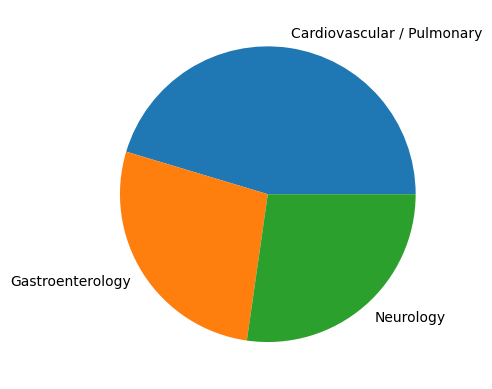

In [7]:
plotutils.plot_category_pie_chart(df_clinical_processed)

To continue, we need to do some tokenization and normalization to our clinical notes in order to visualize them better. I will use spaCy package in this case as it covers a wide range of text tokenization and normalization steps and it is simple and convenient to use.

In [8]:
%%time

notes_doc = list(spacy_pipeline.pipe(df_clinical_processed['notes'].to_list()))

CPU times: total: 29.5 s
Wall time: 29.5 s


After we have done the tokenization, we can plot the histogram of the length of tokens. From the plot, we can see quite a number of clinical notes are longer than 512 and majority of the notes are longer than 256. In this case, we need to be careful if we want to apply some transformer based techniques as the max sequence lengths are limited.

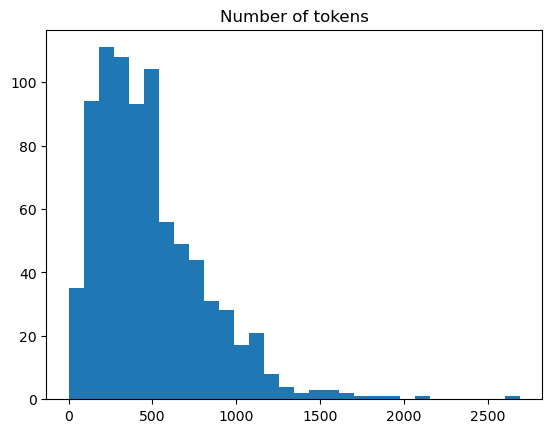

In [9]:
plotutils.plot_token_length_hist(notes_doc)

Let's also plot the histogram of character length for reference.

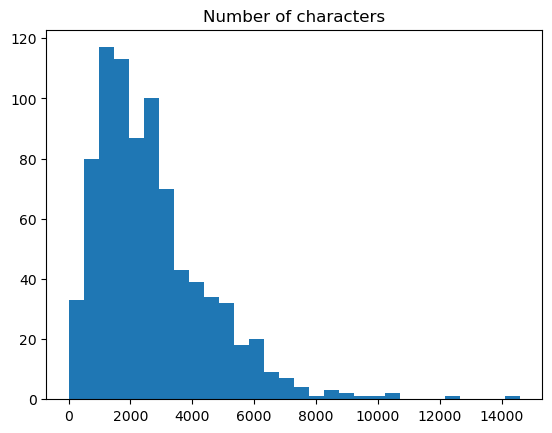

In [10]:
plotutils.plot_char_length_hist(df_clinical_processed['notes'])

To further help us understand what content is in our clinical notes, I decide to plot the word cloud. But there are some practical considerations to make out there. To improve the quality of our wordcloud, I will perform case folding, stopword removal, lemmatization and puncuation removal.

In [11]:
notes_normalized = preprocess.spacy_normalize(notes_doc, stop_removal=True, lemmatized=True)

First I plot the wordcloud with the word importance to be the count of the word in the corpus and basically we can get an idea that the clincal notes are talking about the patients' health conditions and their descriptions.

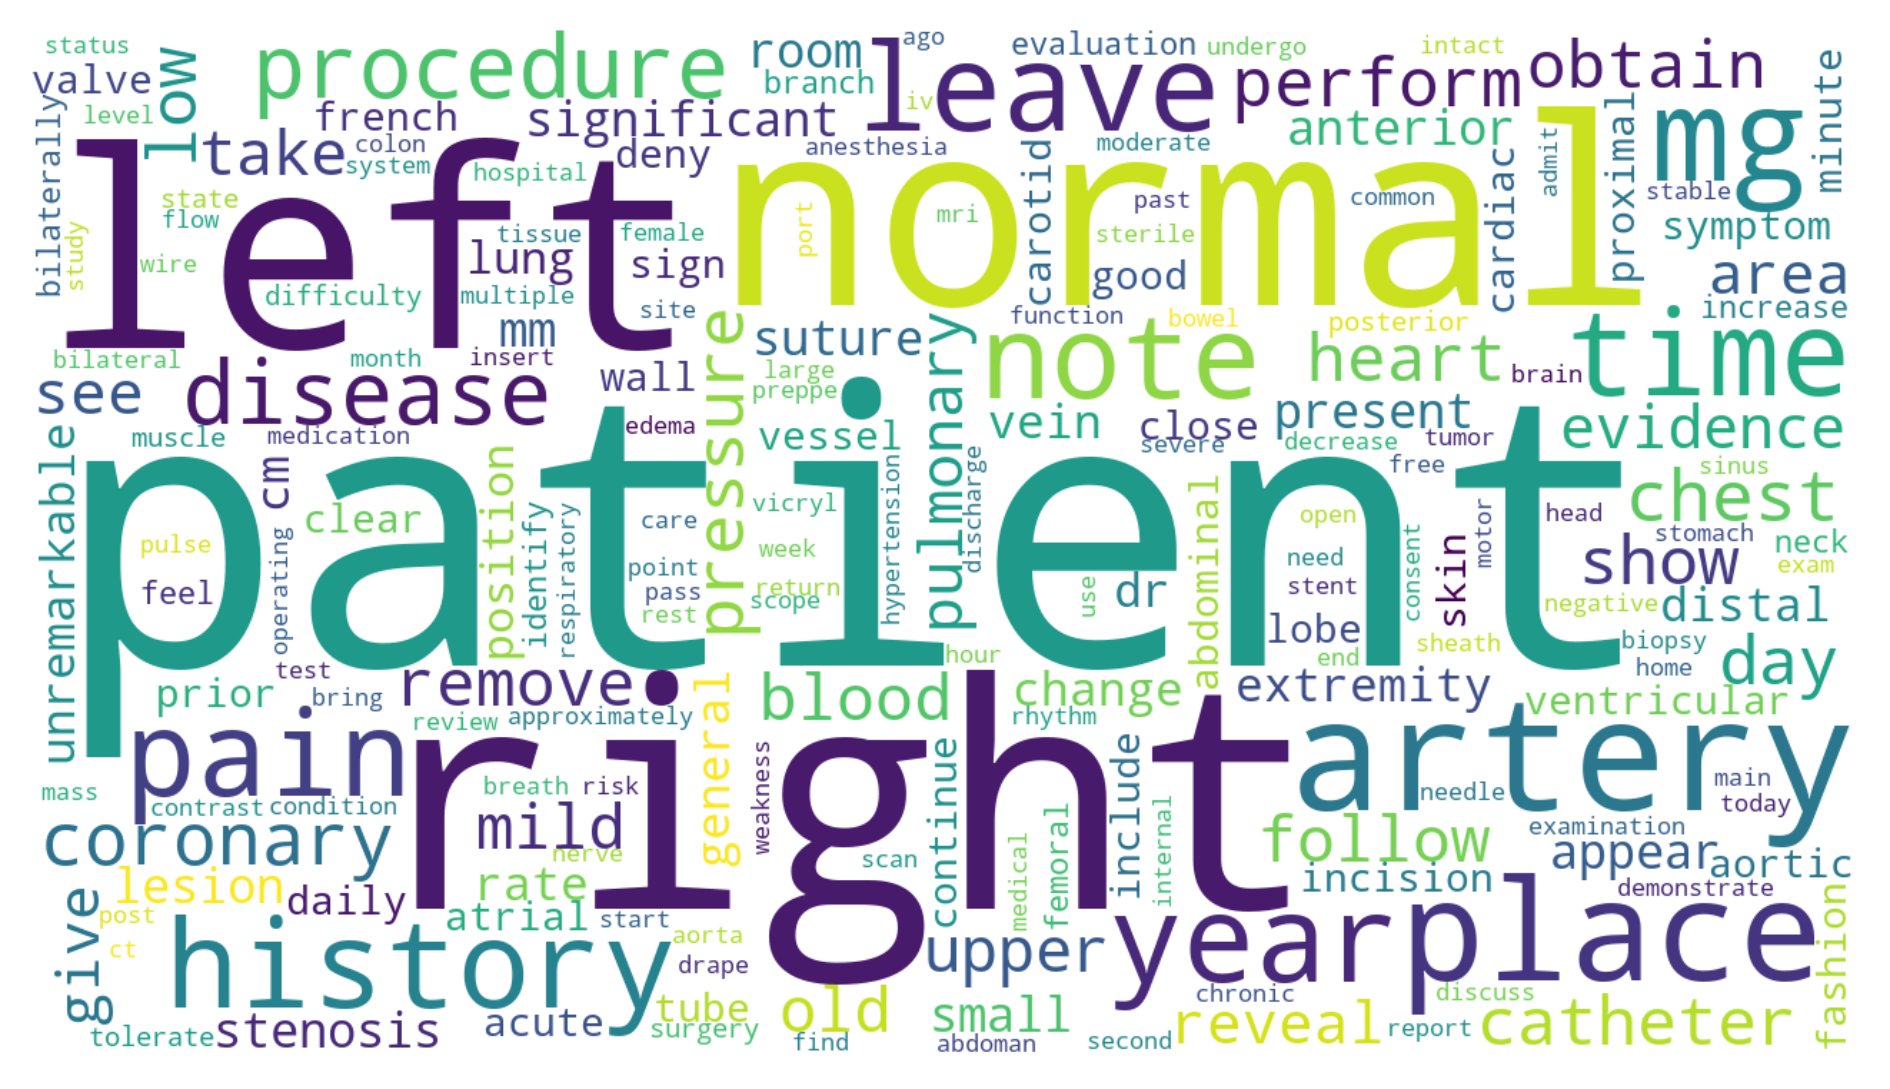

In [12]:
plotutils.plot_wordcloud(notes_normalized, freq_measure='count')

Even though we performed stopword removal, some popular words are still dominating the wordcloud. To improve that, I use TF-IDF vectorization to vectorize each document and obtain the max value across the corpus as the word importance. As the TF-IDF vector is defaulty normalized in scikit-learn, the word importance can be seen as what is the highest importance the word can achieve in the entire corpus. From the result below, we can see more clinical related terms are coming out and it is more informative than the pure word count version.

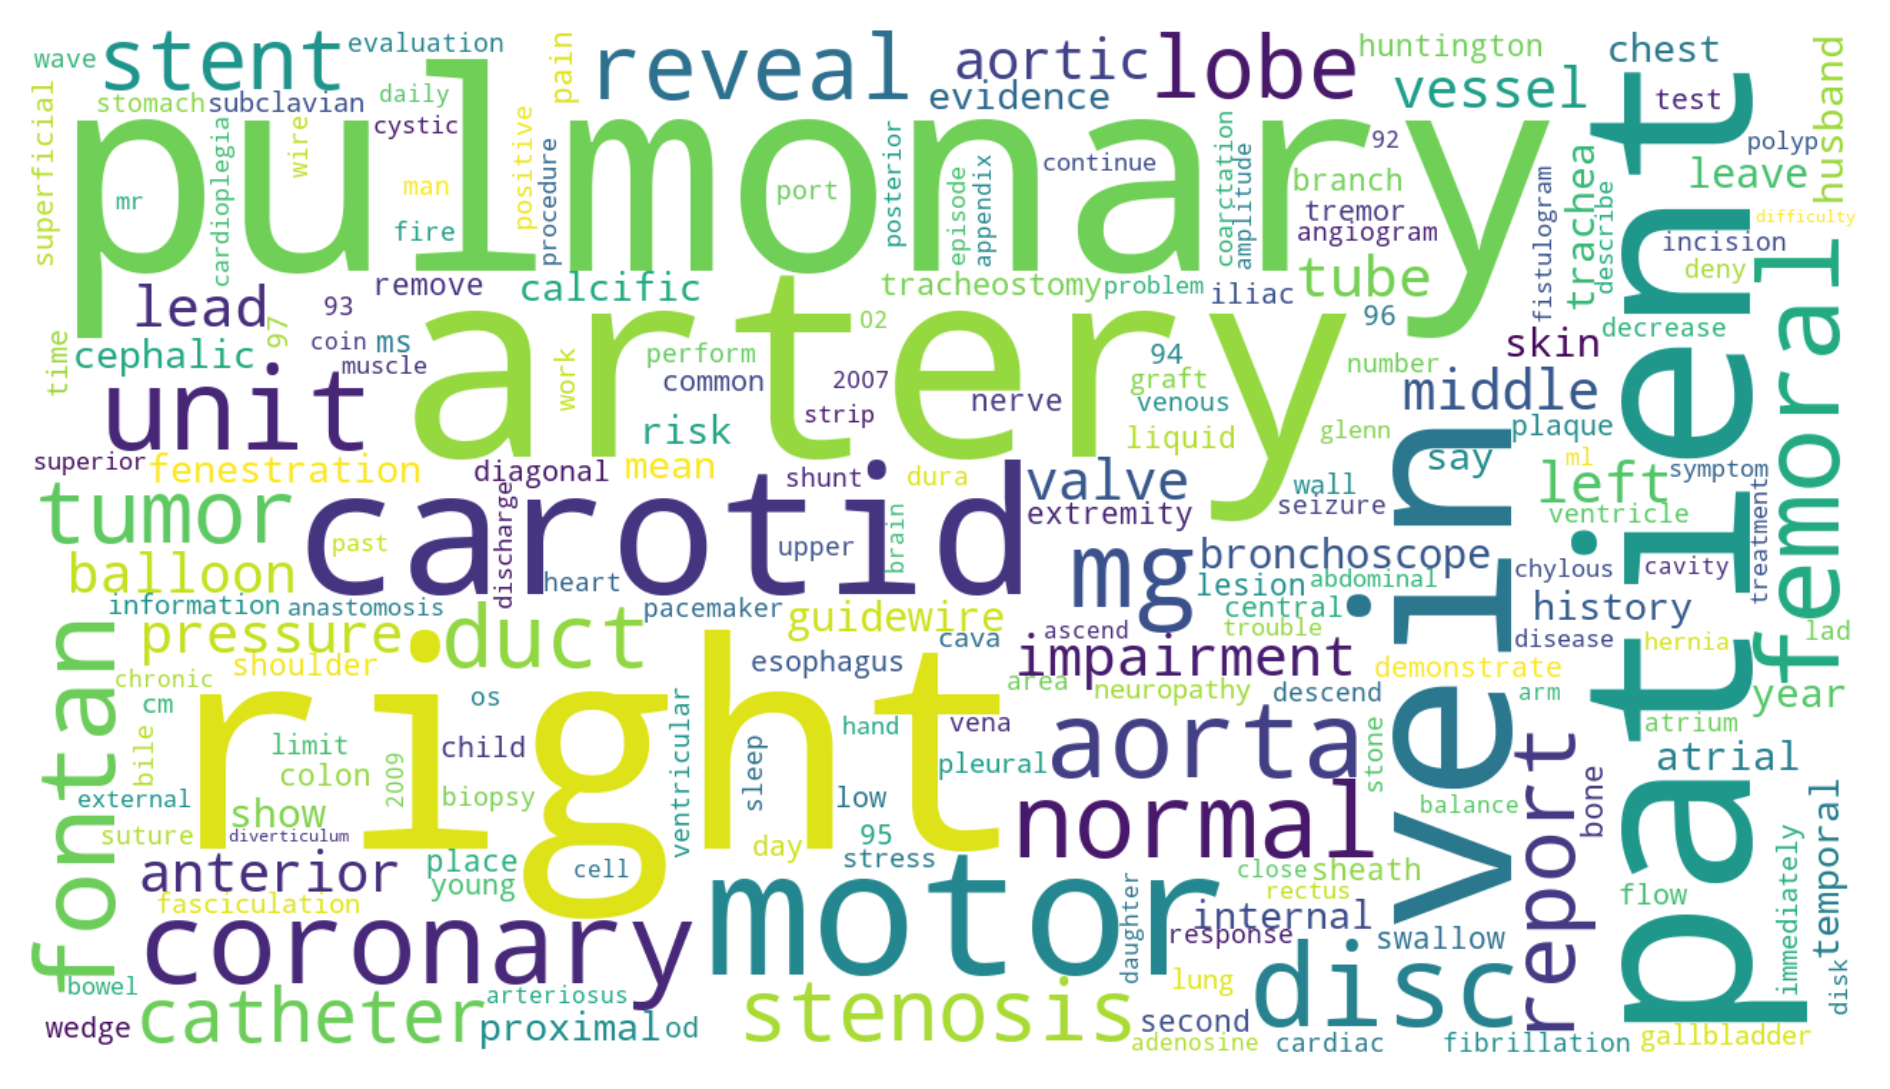

In [13]:
plotutils.plot_wordcloud(notes_normalized, freq_measure='tfidf')

From the explorations we have done above, I decide my normalization steps for the clinical notes as shown below. I change the lemmatization to false because our dataset is relatively small. Again we will save to file for reusing.

In [14]:
notes_list = preprocess.spacy_normalize(notes_doc, lower=True, stop_removal=True, lemmatized=False, punct_removal=True, digit_removal=True)
df_clinical_normalized = df_clinical_processed.copy()
df_clinical_normalized['notes'] = preprocess.join_as_sentence(notes_list)

In [15]:
Path(PROCESSDED_DATA_DIR).mkdir(parents=True, exist_ok=True)
df_clinical_normalized.to_csv(NORMALIZED_CLINICAL_NOTES_FILE, index=False)

# Medical Concepts

For the extra data of related medical concepts, I find it can be interpreted as a undirected graph. So I construct the graph by NetworkX for further processing.

In [16]:
df_medical_concepts = pd.read_csv(MEDICAL_CONCEPTS_FILE)

In [17]:
df_medical_concepts.head()

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol
3,Herpes,Hyperthyroidism
4,Seasickness,Nausea


In [18]:
edges = zip(df_medical_concepts['Term1'].str.lower().to_list(), df_medical_concepts['Term2'].str.lower().to_list())

G = nx.Graph()
G.add_edges_from(edges)

Let's try to print out the immediate neighbours of term 'Nausea'.

In [19]:
for n in G.neighbors('nausea'):
    print(n)

seasickness
vomiting
hyperemesis
zofran
bandemia
uremias
carsickness


Also to get a understanding of connected the terms are, let's print out the top 10 terms with most neighbours.

In [20]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('dyspnea', 12),
 ('fibrillation', 10),
 ('angina', 10),
 ('seizures', 10),
 ('insulin', 10),
 ('diabetes', 10),
 ('arthritis', 9),
 ('cirrhosis', 9),
 ('coumadin', 9),
 ('epilepsy', 9)]

To integrate the related medical terms to our clinical notes, I think we can just simply add related terms to the notes and it will benefit the word frequncy based vectorization method. Because the word sequence does not matter in that case. Here for every term appears in the related medical terms given, I will replace it with itself plus all the immediate neighbours. In practice I think it has to be more thouroughly studied to determine how to add in the neighbours and how far to travel for each term, but it will need some domain knowledge so we just keep it simple here.

In [21]:
df_clinical_extended = df_clinical_normalized.copy()
df_clinical_extended['notes'] = preprocess.join_as_sentence(preprocess.extend_related_terms(G, notes_list))

In [22]:
Path(PROCESSDED_DATA_DIR).mkdir(parents=True, exist_ok=True)
df_clinical_extended.to_csv(EXTENDED_CLINICAL_NOTES_FILE, index=False)